In [1]:
%config InlineBackend.figure_format = 'svg'

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
import astropy.io.ascii as aio
import celerite2
import celerite2.theano
from celerite2.theano import terms as theano_terms
import pandas as pd
import pymc3 as pm
import pymc3_ext as pmx
import scipy.stats as ss
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

In [4]:
data = aio.read("../data/Aldebaran_2017-02-27T1006.txt")
data = pd.DataFrame({'BJD': data['col3'], 'RV': data['col5'], 'RV_err': data['col7']})

Text(0, 0.5, '$v_r / \\mathrm{km} \\, \\mathrm{s}^{-1}$')

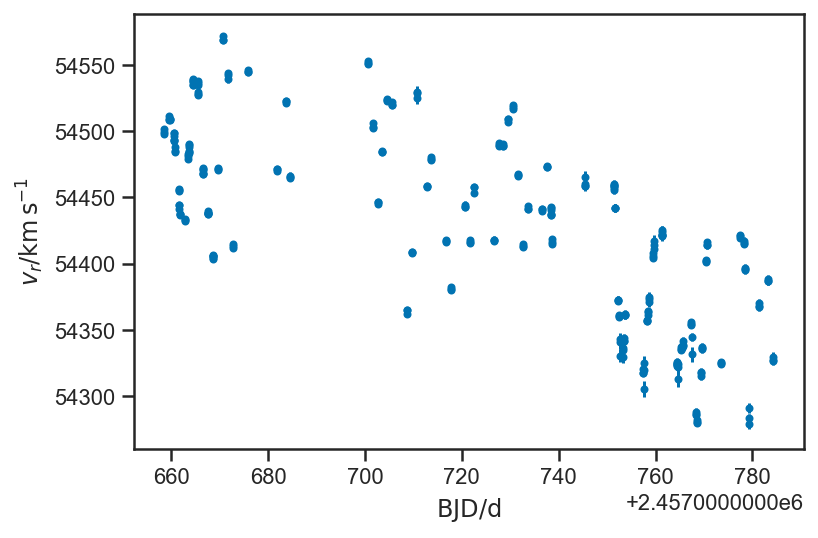

In [5]:
errorbar(data['BJD'], data['RV'], yerr=data['RV_err'], fmt='.')
xlabel(r'$\mathrm{BJD} / \mathrm{d}$')
ylabel(r'$v_r / \mathrm{km} \, \mathrm{s}^{-1}$')

In [6]:
mu_Hz_day = 1/(24.0*3600.0)*1e6

In [7]:
A_sun = 0.2 # m/s
Laldeb = 439 # LSun
Maldeb = 1.16 # MSun
Taldeb = 3900 # K
TSun = 5800 # K

A_aldeb_scaling = Laldeb / (Maldeb**1.5*(Taldeb/TSun)**2.25)
A_aldeb = 60.0 # 170 m/s is the RMS amplitude from Farr+(2018), but who knows how many modes it contains....
A_aldeb_scaling, A_aldeb

(858.21313294463, 60.0)

In [8]:
numax_aldeb = 2.33 # muHz
Dnu_sun = 135.0 # muHz
Dnu_aldeb = (Maldeb)**0.5*(Taldeb/TSun)**3/(Laldeb)**0.75*Dnu_sun
dnu_aldeb = 0.12*Dnu_aldeb
(numax_aldeb, Dnu_aldeb, dnu_aldeb)

(2.33, 0.4609185779612971, 0.05531022935535565)

In [11]:
ts = data['BJD']
ts = ts - median(ts)
M = column_stack((ones_like(ts)/data['RV_err']**2, ts/data['RV_err']**2, ts*ts/data['RV_err']**2))
np.linalg.lstsq(M, data['RV']/data['RV_err']**2)

/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_50766/619994220.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(M, data['RV']/data['RV_err']**2)


(array([ 5.44409164e+04, -1.47978466e+00, -1.43878670e-02]),
 array([34811.35047433]),
 3,
 array([1.65751686e+04, 8.65222244e+01, 2.07445192e+00]))

In [23]:
Nmode = 5
tmid = median(data['BJD'])
rvmid = median(data['RV'])
rng = data['RV'].max() - data['RV'].min()
T = data['BJD'].max() - data['BJD'].min()
ts = array(data['BJD']-tmid)
ts_pred = linspace(np.min(ts), np.max(ts), 1024)
rv = array(data['RV'])
srv = array(data['RV_err'])
psd_freqs = linspace(numax_aldeb-(Nmode//2+2)*Dnu_aldeb, numax_aldeb+(Nmode//2+2)*Dnu_aldeb, 1024)
Q0 = numax_aldeb*T
with pm.Model() as aldeb_model:
    Amax = pm.HalfNormal('Amax', sigma=std(rv))
    sigmaA = pm.HalfNormal('sigmaA', sigma=1)
    fmax = pm.Bound(pm.Normal, lower=0)('fmax', mu=numax_aldeb, sigma=0.1)
    
    f0 = pm.Bound(pm.Normal, lower=0)('f0', mu=numax_aldeb-Nmode//2*Dnu_aldeb, sigma=Dnu_aldeb/2)
    Df = pm.Lognormal('Df', mu=log(Dnu_aldeb), sigma=0.2)
    Q = pm.Bound(pm.Normal, lower=10)('Q', mu=20, sigma=20)
    
    Agran = pm.HalfNormal('Agran', sigma=std(rv))
    fgran = pm.Lognormal('fgran', mu=log(1), sigma=0.1)
    
    a_unit = pm.Normal('a_unit', mu=0, sigma=1)
    b_unit = pm.Normal('b_unit', mu=0, sigma=1)
    c_unit = pm.Normal('c_unit', mu=0, sigma=1)
    
    a = pm.Deterministic('a', -1.43878670e-02 + 2*-1.43878670e-02*a_unit)
    b = pm.Deterministic('b', -1.47978466e+00 + 2*-1.47978466e+00*b_unit)
    c = pm.Deterministic('c', 5.44409164e+04+c_unit)
    
    trend = pm.Deterministic('trend', c + ts*(b + 0.5*ts*a))
    
    fs = pm.Deterministic('fs', f0 + arange(Nmode)*Df)
    xs = (fs - fmax)/(sigmaA*Dnu_aldeb)
    A = pm.Deterministic('A', Amax*exp(-0.5*xs*xs))
    
    ws = 2*pi*fs/mu_Hz_day

    ks = [theano_terms.SHOTerm(sigma=A[i], Q=Q, w0=ws[i]) for i in range(Nmode)]
    k = sum(ks) + theano_terms.RealTerm(a=Agran*Agran, c=fgran/mu_Hz_day)
    
    g = celerite2.theano.GaussianProcess(k)
    g.compute(ts, yerr=srv)
    g.marginal('obs', observed=rv - trend)
    
    stellar_pred = pm.Deterministic('stellar_predict', g.predict(rv-trend, t=ts_pred))
    pred = pm.Deterministic('predict', stellar_pred + c + ts_pred*(b + 0.5*ts_pred*a))
    resid = pm.Deterministic('residual', rv-trend-g.predict(rv-trend, t=ts))
    psd = pm.Deterministic('psd', g.kernel.get_psd(2*pi*psd_freqs/mu_Hz_day)*2*pi/mu_Hz_day)

In [30]:
aldeb_model.logp_array(aldeb_model.bijection.map(aldeb_model.test_point))

array(-1074.66542869)

In [31]:
aldeb_model.dlogp_array(aldeb_model.bijection.map(aldeb_model.test_point))

array([-1.04914378e-02, -3.49495919e-01,  8.21818191e-01,  3.85672124e+04,
       -4.53595101e+06, -1.02691722e+00,  2.50359498e+04,  4.15361303e+04,
       -2.79264228e+04, -1.34464013e+04, -2.81620510e+04])

In [15]:
with aldeb_model:
    aldeb_best = pmx.optimize()

optimizing logp for variables: [c_unit, b_unit, a_unit, fgran, Agran, Q, Df, f0, fmax, sigmaA, Amax]


message: Optimization terminated successfully.
logp: -1079.5152940228843 -> -885.6112535473842


In [16]:
aldeb_best['A'], aldeb_best['Agran'], aldeb_best['fs'], aldeb_best['fmax']

(array([38.67029991, 40.27860305, 22.65584778]),
 array(12.27306635),
 array([2.03387682, 2.52568135, 3.01748587]),
 array(2.31230409))

Text(0, 0.5, '$v_r / \\mathrm{km} \\, \\mathrm{s}^{-1}$')

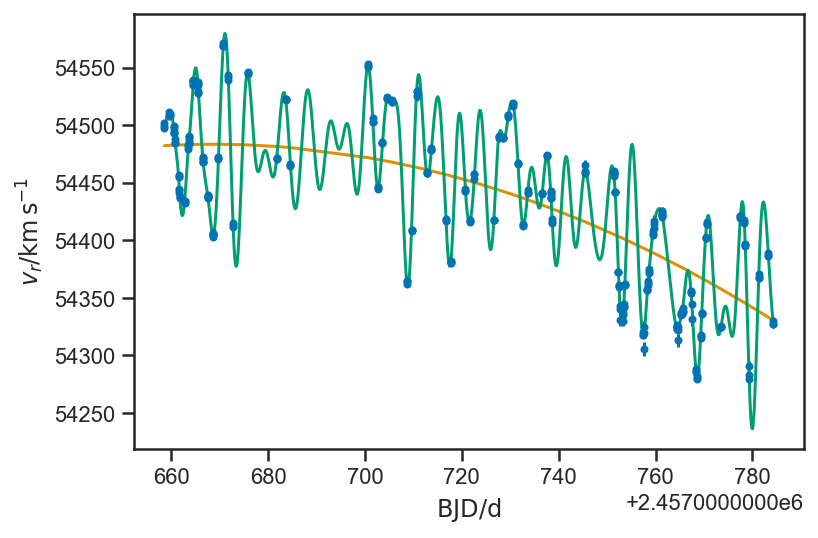

In [17]:
errorbar(data['BJD'], data['RV'], yerr=data['RV_err'], fmt='.')
plot(ts+tmid, aldeb_best['trend'])
plot(ts_pred+tmid, aldeb_best['predict'])
xlabel(r'$\mathrm{BJD} / \mathrm{d}$')
ylabel(r'$v_r / \mathrm{km} \, \mathrm{s}^{-1}$')

Text(0.5, 0, '$r_i / \\sigma_i$')

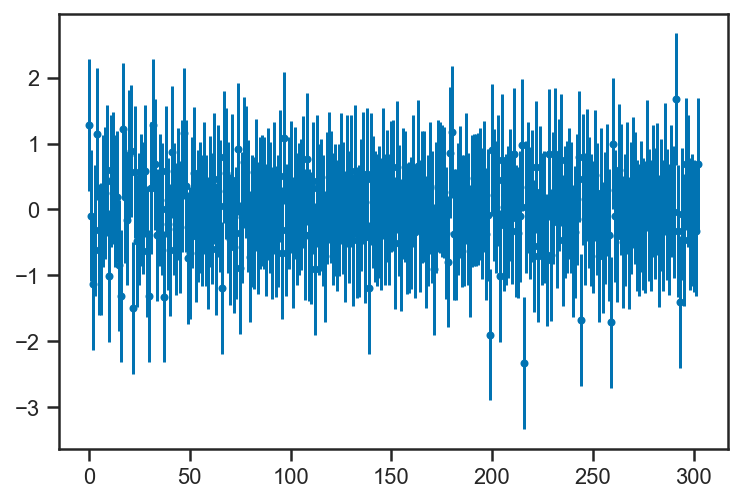

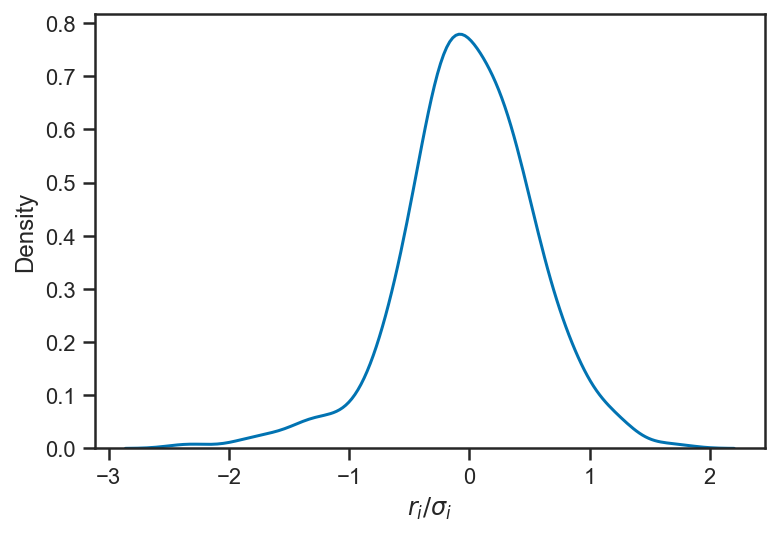

In [18]:
errorbar(arange(len(aldeb_best['residual'])), aldeb_best['residual']/data['RV_err'], yerr=ones_like(data['RV_err']), fmt='.')

figure()
sns.kdeplot(aldeb_best['residual'] / data['RV_err'])
xlabel(r'$r_i / \sigma_i$')

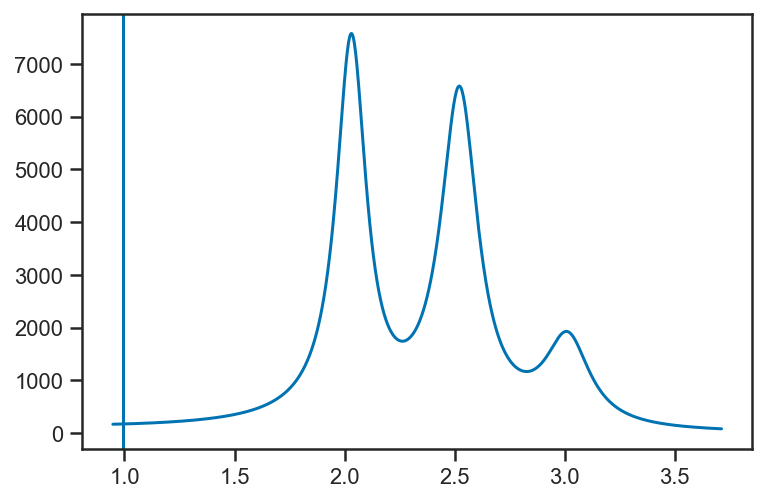

In [19]:
plot(psd_freqs, aldeb_best['psd'])
axvline(aldeb_best['fgran'])

In [20]:
with aldeb_model:
    aldeb_trace = pmx.sample()

KeyboardInterrupt: 

/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'fs'}>,
        <AxesSubplot:title={'center':'fs'}>],
       [<AxesSubplot:title={'center':'Df'}>,
        <AxesSubplot:title={'center':'Df'}>],
       [<AxesSubplot:title={'center':'fmax'}>,
        <AxesSubplot:title={'center':'fmax'}>],
       [<AxesSubplot:title={'center':'Q'}>,
        <AxesSubplot:title={'center':'Q'}>],
       [<AxesSubplot:title={'center':'Agran'}>,
        <AxesSubplot:title={'center':'Agran'}>],
       [<AxesSubplot:title={'center':'fgran'}>,
        <AxesSubplot:title={'center':'fgran'}>]], dtype=object)

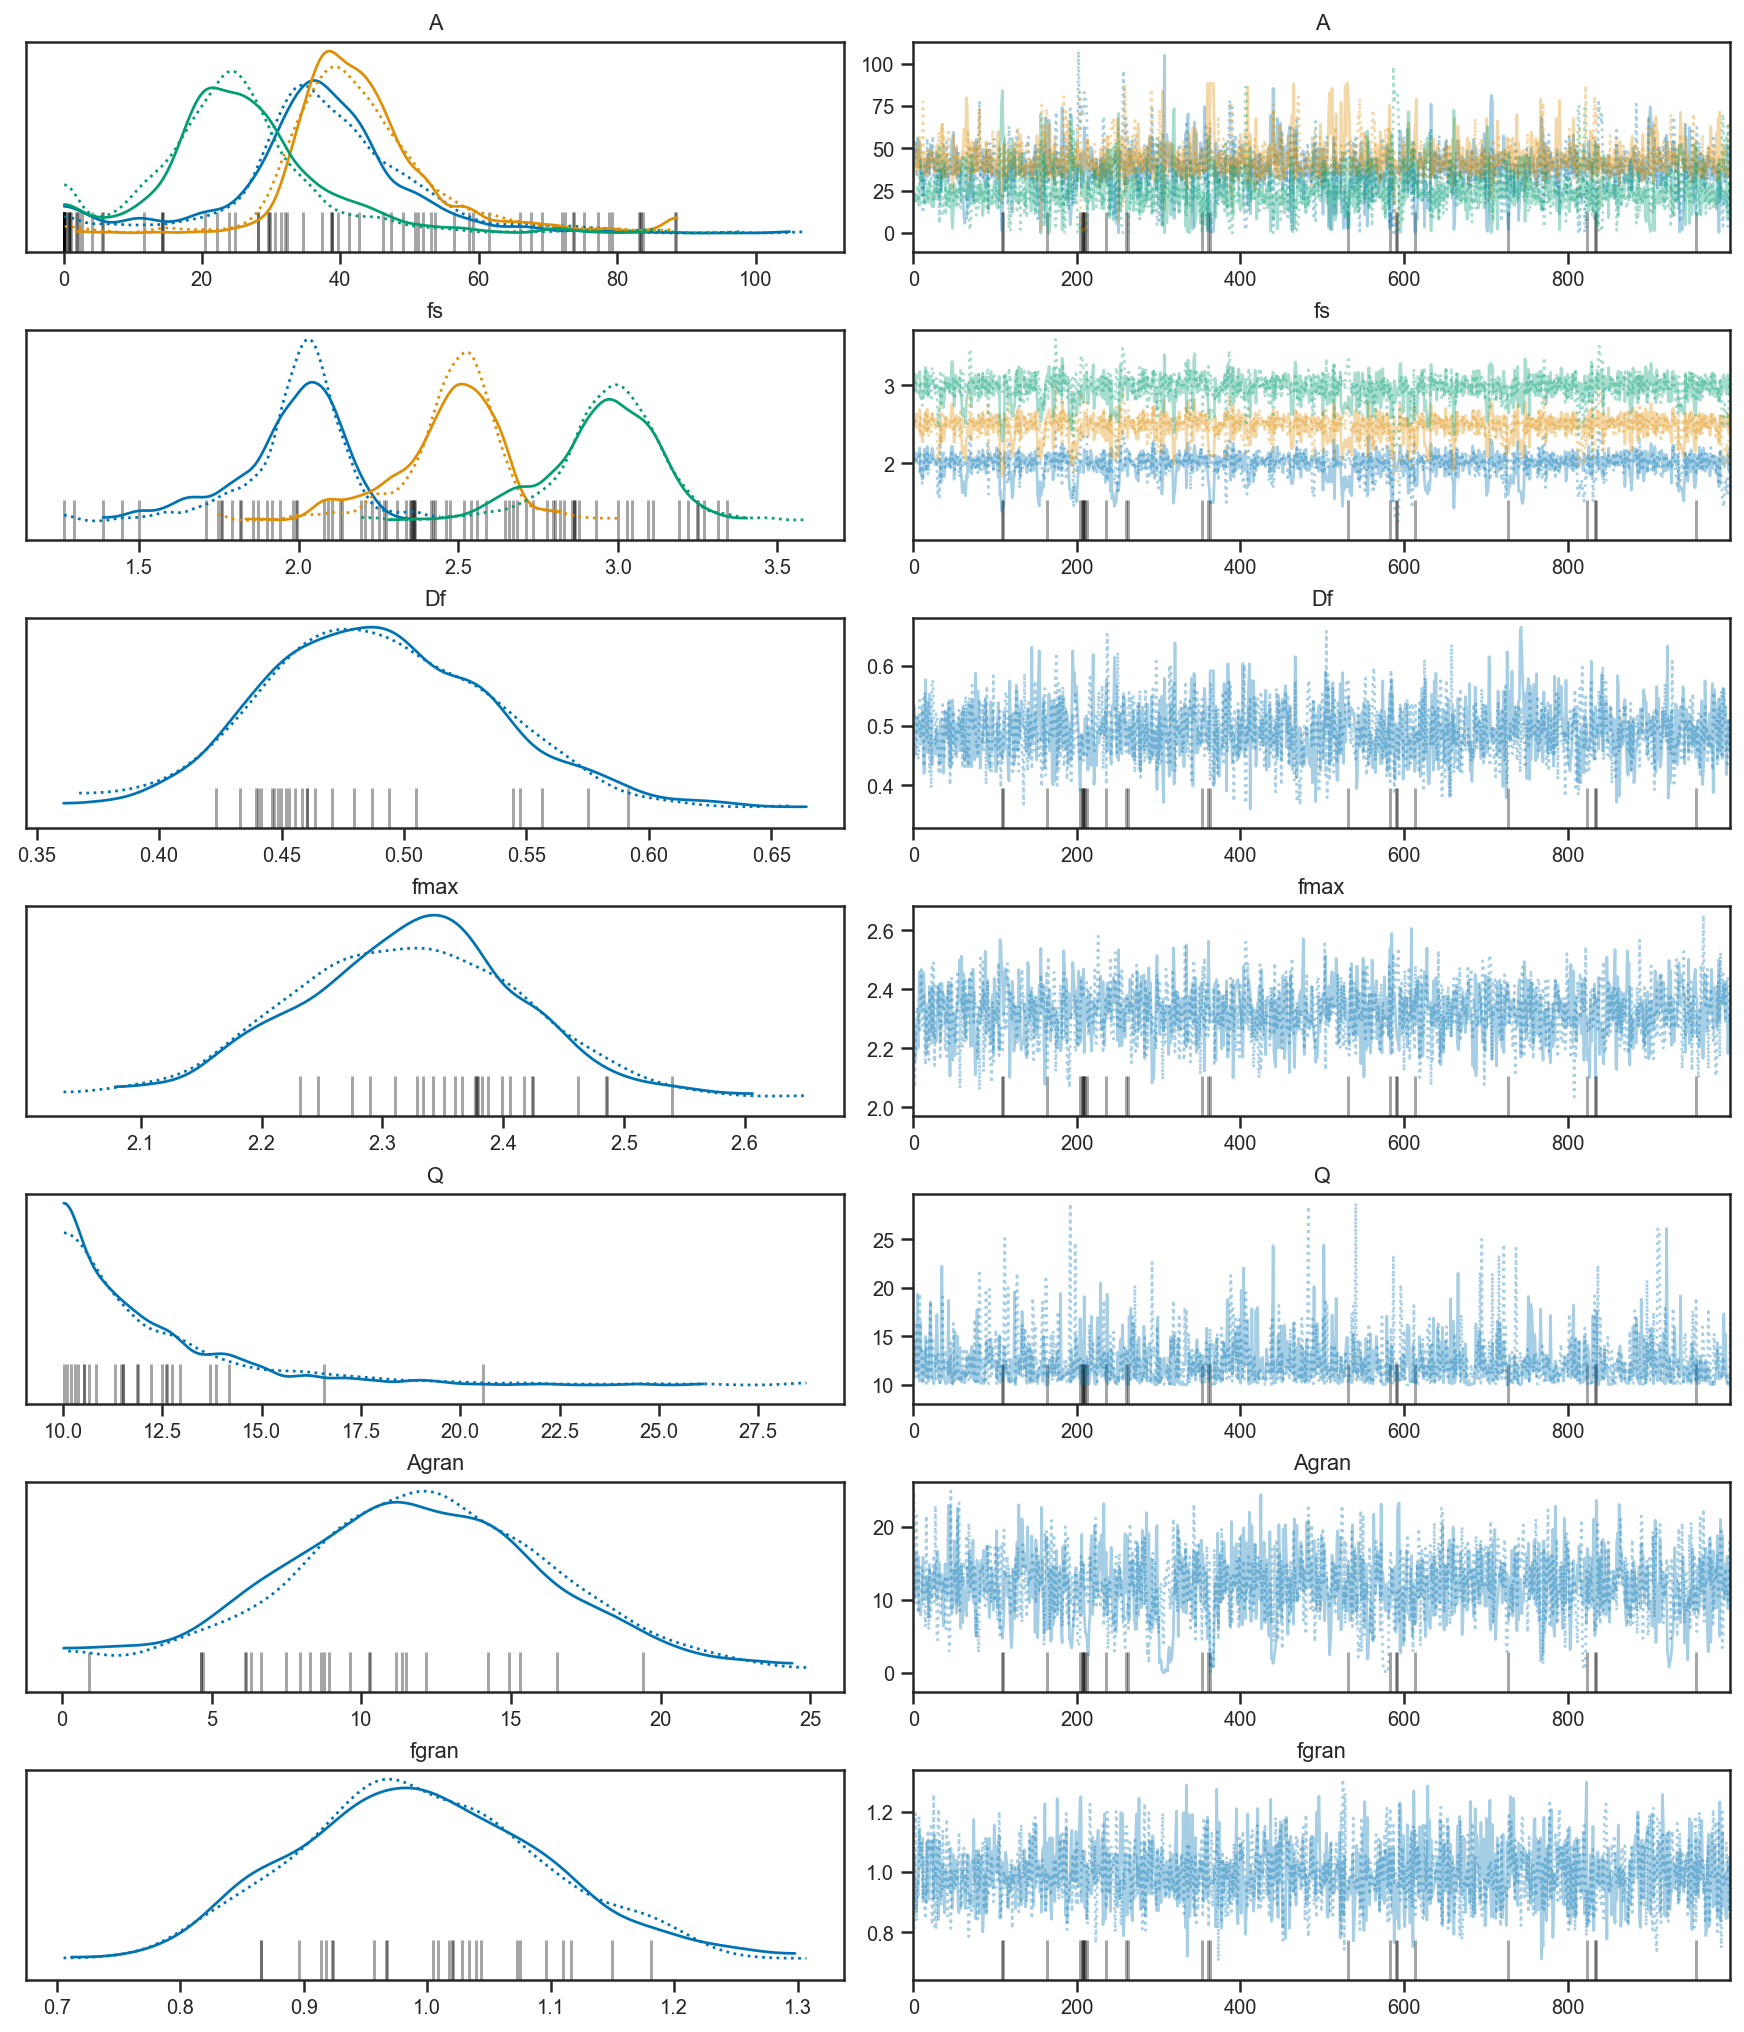

In [394]:
pm.plot_trace(aldeb_trace, var_names=['A', 'fs', 'Df', 'fmax', 'Q', 'Agran', 'fgran'])

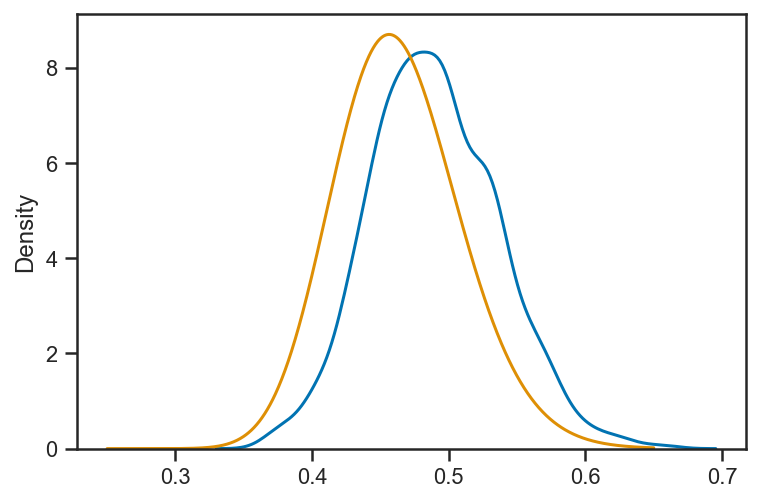

In [395]:
sns.kdeplot(aldeb_trace['Df'])
xs = linspace(0.25, 0.65, 1024)
plot(xs, ss.lognorm(0.1, scale=Dnu_aldeb).pdf(xs))

Text(0, 0.5, '$P(f) / \\mathrm{m}^2 \\, \\mathrm{s}^{-2} \\, \\mu\\mathrm{Hz}^{-1}$')

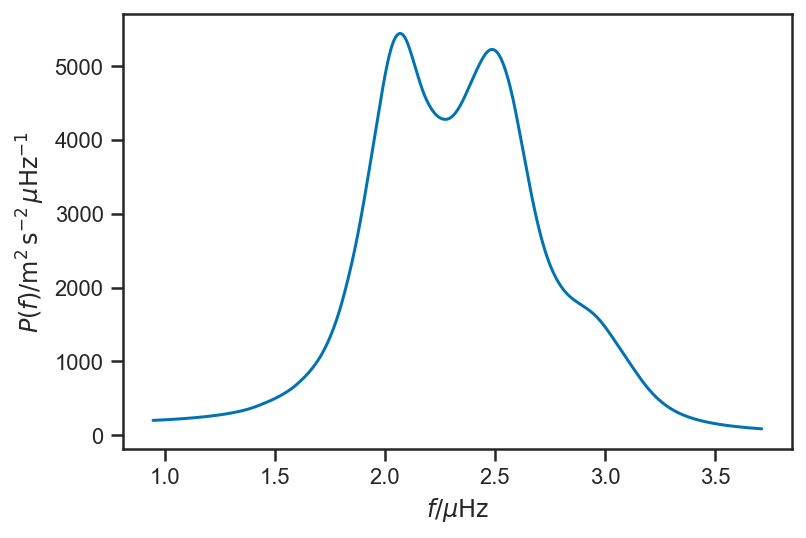

In [396]:
plot(psd_freqs, mean(aldeb_trace['psd'], axis=0))
xlabel(r'$f / \mu\mathrm{Hz}$')
ylabel(r'$P(f) / \mathrm{m}^2 \, \mathrm{s}^{-2} \, \mu\mathrm{Hz}^{-1}$')

Text(0, 0.5, '$v_r / \\mathrm{km} \\, \\mathrm{s}^{-1}$')

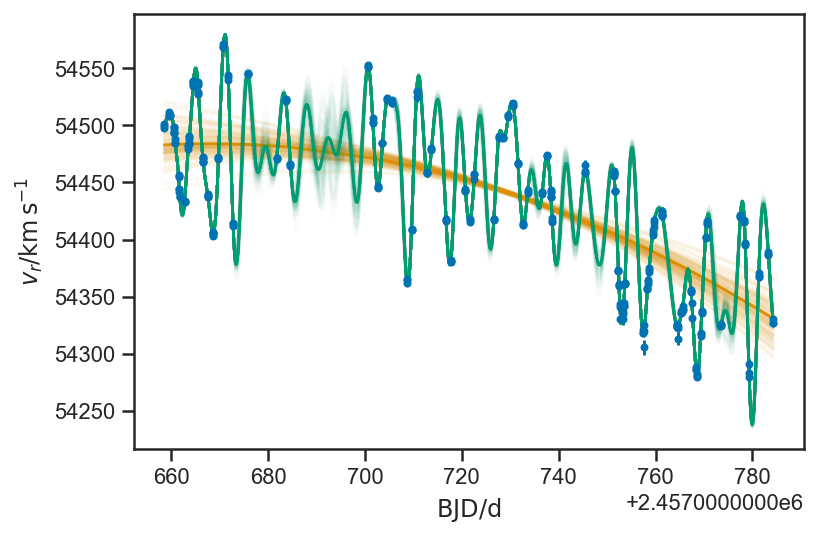

In [397]:
errorbar(data['BJD'], data['RV'], yerr=data['RV_err'], fmt='.')
l, = plot(ts+tmid, mean(aldeb_trace['trend'], axis=0))
for _ in range(100):
    plot(ts+tmid, aldeb_trace['trend'][randint(2000),:], alpha=0.05, color=l.get_color())
l, = plot(ts_pred+tmid, mean(aldeb_trace['predict'], axis=0))
for _ in range(100):
    plot(ts_pred+tmid, aldeb_trace['predict'][randint(2000),:], alpha=0.01, color=l.get_color())
xlabel(r'$\mathrm{BJD} / \mathrm{d}$')
ylabel(r'$v_r / \mathrm{km} \, \mathrm{s}^{-1}$')